#**HW4 : Recurrent Neural Networks**
In this homework, we will explore how to develop a simple Recurrent Neural Network (RNN) for sentiment analysis. As a dataset, we will use the IMDB dataset. It contains the text of some reviews and the sentiment given by the authors of the reviews (positive review or negative review). The input to the RNN is the sequence of words that compose a review. The learning task consists in predicting the sentiment of the review.
In the first part, we will learn how to develop a simple RNN, then we will explore the differences in terms of computational load, number of parameters, and performances with respect to more advanced recurrent models, like LSTM and GRU. Subsequently, we experiment with the bi-directional model to unveil the strengths and the weaknesses of this technique. Finally, we will explore how to face overfitting by Dropout. 

##[TO COMPLETE] Exercise 4.1: Simple RNN

Let's start by importing Tensorflow, Keras and Numpy

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

np.random.seed(42)

###Load dataset:
In this HW, we use the same datset used in the HW2, the IMDB dataset. The dataset contains 50,000 movie reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes. For convenience, the words are indexed by the overall frequency in the dataset, so that for example the integer "3" encodes the 3rd most frequent word in the data. For testing purposes, we will only consider the first 10,000  most common words.
By default, the load_data method returns a breakdown of the dataset into training and test sets. Both these sets contain 25,000 samples. To also have a validation set, we split the test set in half.

In [3]:

num_words = 10000
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=num_words)
(X_valid, X_test) = X_test[:12500], X_test[12500:]
(y_valid, y_test) = y_test[:12500], y_test[12500:]

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

Let's also get the word indexs (word to word-id)

In [4]:
word_index = keras.datasets.imdb.get_word_index()

1646592/1641221 [==============================] - 0s 0us/step


Now we create a reverse index (word-id to word) method. Moreover, we add three special word-ids to encode:
- the padding;
- the start of a sequence;
- a word that is not in the vocabulary of the first 10,000 most common words.

Moreover, we also add an "unknown" placeholder for all the other symbols (not words) that may occur.
*Please, notice that Keras does not use index 0, so we can shift the indices only by 3 positions.*

In [5]:
reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

Let's print a training sample and its target value

In [6]:
decode_review(X_train[0])

"<sos> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <oov> is an amazing actor and now the same being director <oov> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <oov> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <oov> to the two little boy's that played the <oov> of norman and paul they were just brilliant children are often left out of the <oov> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what

In [7]:
y_train[0]

1

Because of a limit of Keras, to feed the input data into an RNN model we have to create sequences that have the same length. We use keras.preprocessing.sequence.pad_sequences() to preprocess X_train: this will create a 2D array of 25,000 rows (one per review) and maxlen=500 columns. Because of that, reviews longer than 500 words will be cut, while reviews shorter than 500 words will be padded with zeros.

In [8]:
maxlen = 500
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

###[TO COMPLETE] Define the model:
Let's define the model: 
- The first layer is an Embedding layer, with input_dim=num_words and output_dim=10. The model will gradually learn to represent each of the 10,000 words as a 10-dimensional vector. So the next layer will receive 3D batches of shape (batch size, 500, 10)
- The second layer is the recurrent one. In particular, in this case, we use a [SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) 
- The output layer is a Dense layer with a sigmoid activation function since this is a binary classification problem

[TO COMPLETE] In the following cell, we already inserted in the model the first Embedding layer. Add the recurrent layer (using 32 units), and the output layer. Select the right activation function for the output layer and motivate your choice. Finally, select the right loss function inserting the right value for the "loss" parameter in model.compile() and motivate your choice.
Please, insert your answers in a new text cell below this one, immediately before the code.

The loss function I choose is binary crossentropy, since it is a binary classification problem (output is 0 or 1). Also, I choose only one unit on the output layer since we are using the sigmoid activation function. Sigmoid is a one variable function, so it can be used when there is a single unit, tipically on these binary classification problems. It can also be applied to more units layers, but the outputs  of each neuron after applying the sigmoid (the probabilities) are independent, unlike the softmax that intercorrelates the different outputs.

 The layer architecture might have been aproached differently. It could have had two units, with the softmax activation function (multivariate function), each neuron would correspond to one label (0 and 1), and the output would be the one with higher output (higher probability). But with only 1 unit, it is simpler and saves in computation costs.



In [9]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.SimpleRNN(32, activation='tanh'))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Let's print a summary of the model. Specifically, note the number of parameters of the RNN layer.

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 10)          100000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                1376      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 101,409
Trainable params: 101,409
Non-trainable params: 0
_________________________________________________________________


###Train the model:
Now we have to train the model

In [11]:
history = model.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/10
196/196 [==============================] - 28s 137ms/step - loss: 0.6821 - accuracy: 0.5526 - val_loss: 0.5815 - val_accuracy: 0.7206
Epoch 2/10
196/196 [==============================] - 26s 132ms/step - loss: 0.4699 - accuracy: 0.7920 - val_loss: 0.3932 - val_accuracy: 0.8310
Epoch 3/10
196/196 [==============================] - 26s 132ms/step - loss: 0.3014 - accuracy: 0.8818 - val_loss: 0.3692 - val_accuracy: 0.8533
Epoch 4/10
196/196 [==============================] - 26s 133ms/step - loss: 0.2488 - accuracy: 0.9063 - val_loss: 0.3586 - val_accuracy: 0.8454
Epoch 5/10
196/196 [==============================] - 26s 133ms/step - loss: 0.1992 - accuracy: 0.9305 - val_loss: 0.4103 - val_accuracy: 0.8334
Epoch 6/10
196/196 [==============================] - 26s 133ms/step - loss: 0.2133 - accuracy: 0.9204 - val_loss: 0.3803 - val_accuracy: 0.8531
Epoch 7/10
196/196 [==============================] - 26s 132ms/step - loss: 0.1492 - accuracy: 0.9461 - val_loss: 0.4187 - val_ac

Print the values of accuracy and the loss , and evaluate the model on the test set

391/391 - 7s - loss: 0.4616 - accuracy: 0.8541
accuracy: 85.41%


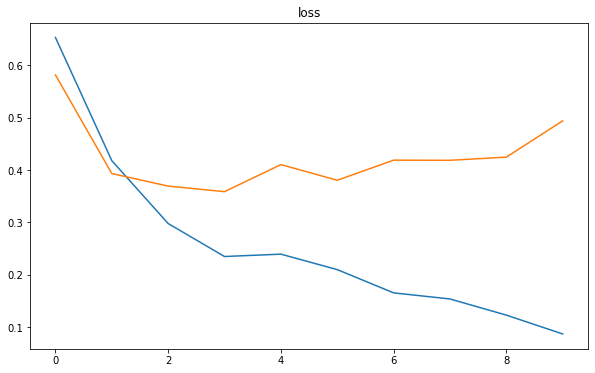

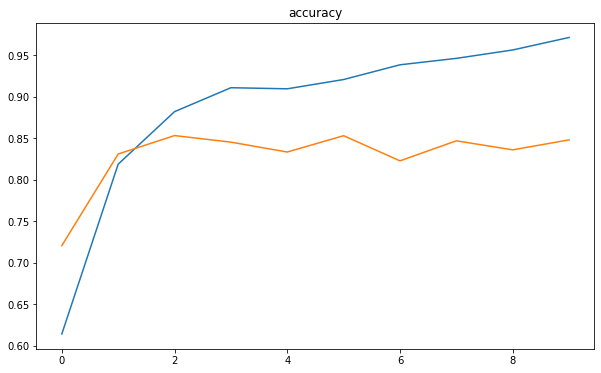

In [12]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['accuracy'])
  plt.plot(history.epoch,history.history['val_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_accuracy(history)

scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

##[TO COMPLETE] Exercise 4.2: LSTM and GRU
**[TO COMPLETE]**: In this Exercise, you have to implement 2 models, similar to the previous one that, instead of exploiting the RNN layer, use an LSTM and a GRU Layer, respectively. For each model print the summary. Then, train it and plot the values of accuracy and loss. Finally, discuss the differences in terms of performance, the number of parameters, and training time. Note that you can use a different number of units than the one used in the RNN example.

**[TO COMPLETE]**: In order to perform a fair comparison (definition of fair: models have to use more or less the same number of parameters) between the given RNN model and the other 2 models (LSTM and GRU), how many units do they have to use, respectively?

*insert cells (code and text) with results and discussion immediately after this cell*

HOW MANY UNITS TO MAKE A FAIR COMPARISON?

To make a fair comparison we have to match the number of parameters of the different models. The simpleRNN model has a total of 101,409 parameters if the recurrent layer has 32 units (this layer has 1376). The LSTM model, with 14 units on the lstm layer has 101,415. Finally, the GRU model with 16 units respectively has 101,361. So they need around a half of the units in this case to have a similar number of parameters. The function of number of parameters in the model with respect of the number of units in the recurrent layer is non linear, so this relationship is not always true. This means the number of parameters does not grow at the same rate in all these models when increasing the number of units.

COMPARISON BETWEEN THE MODELS

Both of the models take a similar time to train. LSTM takes around 241 ms/step while GRU takes 250. It is also true that the first one has 54 more trainable parameters because of the number of units I chose. The LSTM achieves a very similar, slightly better performance on the test set than the GRU model (similar accuracy, better loss): +0.0059 accuracy, -0.056 loss.

In comparison with the SimpleRNN model (with a similar number of parameters), this one takes much less time to train, around 137 ms/step, and achieves a similar accuracy adn loss on the test set.

The three of the models overfit with the current number of units. The distance between their performance on the test set and on the training set is similar. The only difference is that the LSTM model reaches a slightly higher validation accuracy around the 5th epoch (87%).

CODE AND GRAPHICS:

In [13]:
model_LSTM = keras.models.Sequential()
model_LSTM.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_LSTM.add(keras.layers.LSTM(14, activation='tanh'))
model_LSTM.add(keras.layers.Dense(1, activation="sigmoid"))

model_LSTM.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
lstm (LSTM)                  (None, 14)                1400      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 15        
Total params: 101,415
Trainable params: 101,415
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
196/196 [==============================] - 49s 241ms/step - loss: 0.6534 - accuracy: 0.6157 - val_loss: 0.4372 - val_accuracy: 0.8180
Epoch 2/10
196/196 [==============================] - 50s 253ms/step - loss: 0.3761 - accuracy: 0.8562 - val_loss: 0.3400 - val_accuracy: 0.8626
Epoch 3/10
196/196 [==============================] - 51s 259ms/step - loss: 0.2575 - accuracy: 0.9094 - val_loss: 0.3175 - val_accuracy: 0.8697
Epoch 4/10
196/196 [==============================] - 50s 256ms/step - loss: 0.2060 - accuracy: 0.9296 - val_loss: 0.3391 - val_accuracy: 0.8691
Epoch 5/10
196/196 [==============================] - 50s 257ms/step - loss: 0.1669 - accuracy: 0.9462 - val_loss: 0.3243 - val_accuracy: 0.8708
Epoch 6/10
196/196 [==============================] - 53s 269ms/step - loss: 0.1376 - accuracy: 0.9561 - val_loss: 0.3591 - val_accuracy: 0.8667
Epoch 7/10
196/196 [==============================] - 51s 260ms/step - loss: 0.1260 - accuracy: 0.9614 - val_loss: 0.3900 - val_ac

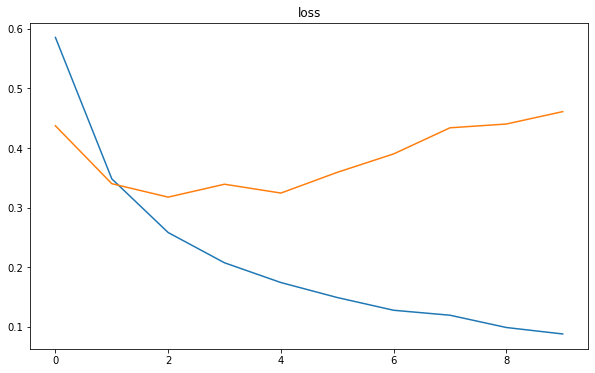

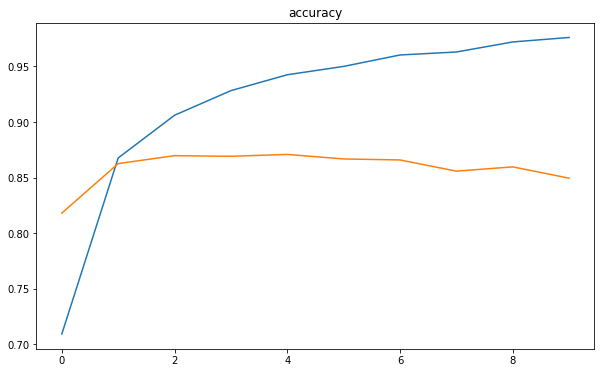

In [14]:
history = model_LSTM.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

plot_loss(history)

plot_accuracy(history)

scores = model_LSTM.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_LSTM.metrics_names[1], scores[1]*100))

In [15]:
model_GRU = keras.models.Sequential()
model_GRU.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_GRU.add(keras.layers.GRU(16, activation='tanh'))
model_GRU.add(keras.layers.Dense(1, activation="sigmoid"))

model_GRU.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_GRU.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
gru (GRU)                    (None, 16)                1344      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 101,361
Trainable params: 101,361
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
196/196 [==============================] - 48s 235ms/step - loss: 0.6612 - accuracy: 0.5900 - val_loss: 0.4900 - val_accuracy: 0.7592
Epoch 2/10
196/196 [==============================] - 49s 250ms/step - loss: 0.3615 - accuracy: 0.8446 - val_loss: 0.3542 - val_accuracy: 0.8526
Epoch 3/10
196/196 [==============================] - 49s 248ms/step - loss: 0.2416 - accuracy: 0.9071 - val_loss: 0.3469 - val_accuracy: 0.8536
Epoch 4/10
196/196 [==============================] - 49s 251ms/step - loss: 0.2081 - accuracy: 0.9232 - val_loss: 0.3567 - val_accuracy: 0.8594
Epoch 5/10
196/196 [==============================] - 49s 250ms/step - loss: 0.1695 - accuracy: 0.9403 - val_loss: 0.3619 - val_accuracy: 0.8564
Epoch 6/10
196/196 [==============================] - 49s 249ms/step - loss: 0.1402 - accuracy: 0.9536 - val_loss: 0.3817 - val_accuracy: 0.8599
Epoch 7/10
196/196 [==============================] - 49s 250ms/step - loss: 0.1215 - accuracy: 0.9607 - val_loss: 0.4187 - val_ac

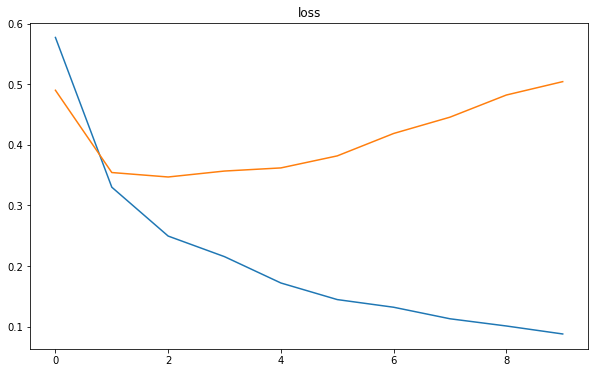

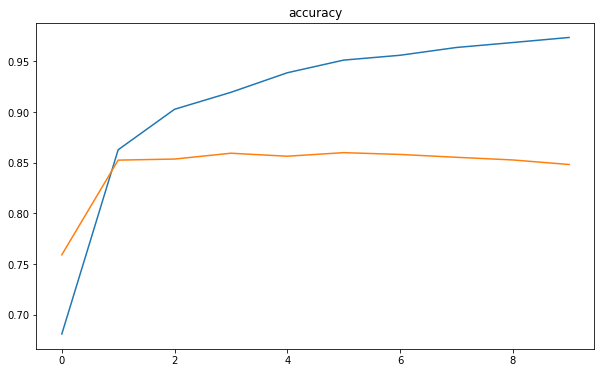

In [16]:
history = model_GRU.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

plot_loss(history)

plot_accuracy(history)

scores = model_GRU.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_GRU.metrics_names[1], scores[1]*100))

##Bidirectional LSTM
Let's modify the previous code by using a bidirectional LSTM instead of a simple LSTM. In Keras, it is possible to define a bidirectional layer by using [tf.keras.layers.Bidirectional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional). Note that this wrapper requires as argument a layer, in our case we use [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)


In [17]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=5, batch_size=128, validation_data=(X_valid_trim, y_valid))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                11008     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
196/196 [==============================] - 116s 576ms/step - loss: 0.6371 - accuracy: 0.6218 - val_loss: 0.3647 - val_accuracy: 0.8466
Epoch 2/5
196/196 [==============================] - 113s 576ms/step - loss: 0.2875 - accuracy: 0.8888 - val_loss: 0.2940 - val_accuracy: 0.8777
Epoch 3/5
196/196 [==============================] - 113s 576ms/step - loss: 0.2007 - ac

391/391 - 20s - loss: 0.3463 - accuracy: 0.8764
accuracy: 87.64%


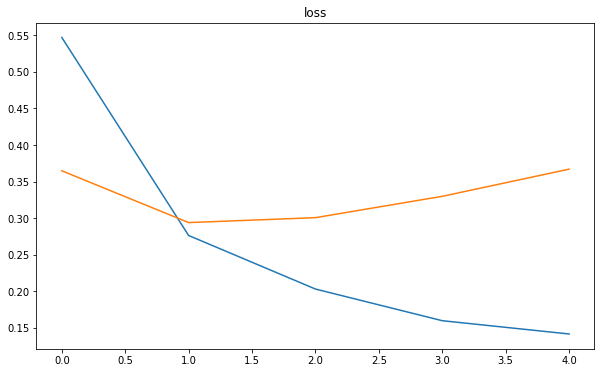

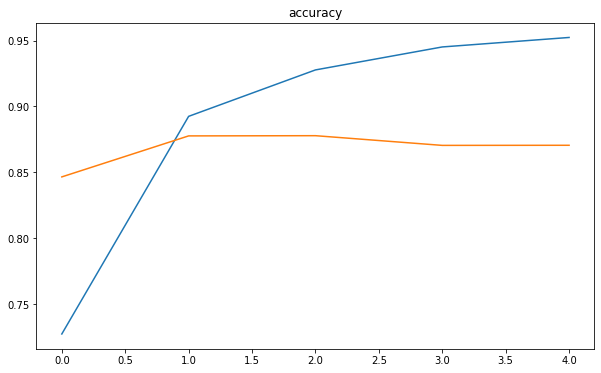

In [18]:
plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

##[TO COMPLETE] Exercise 4.3: Dropout
In the bi-directional model is it possible to notice that the model overfits the training data.
A possible solution to this problem could be applying the dropout technique to input or output layers.

In Keras, to apply dropout you have to add a [keras.layers.Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layer.

**[TO COMPLETE]**: modify the code of the previous exercise adding the Dropout to the input and/or output layers. Find the Dropout probability that reduces the overfitting issue.

**[TO COMPLETE]** Is it possible to modify the values of some other hyper-parameters to mitigate overfitting? And if this is the case, explain why and perform an experimental study demonstrating your point.

*insert cells (code and text) with results and discussion immediately after this cell*

DROPOUT

- With two dropout layers, with 0.5 prob

loss: 0.2827 - accuracy: 0.8849 on test set

loss: 0.2023 - accuracy: 0.9269 on training set

val_loss: 0.3011 - val_accuracy: 0.8790 on validation set

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
dropout (Dropout)            (None, None, 10)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                11008     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
196/196 [==============================] - 122s 601ms/step - loss: 0.6589 - accuracy: 0.5788 - val_loss:

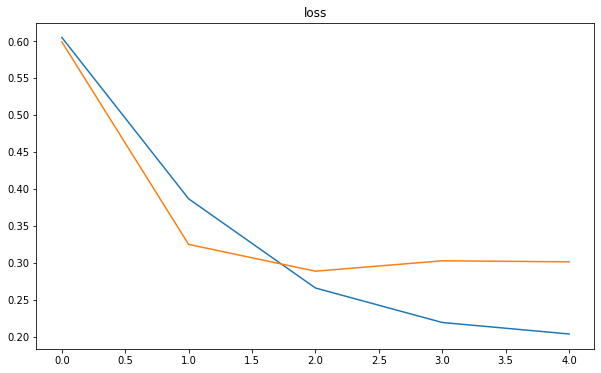

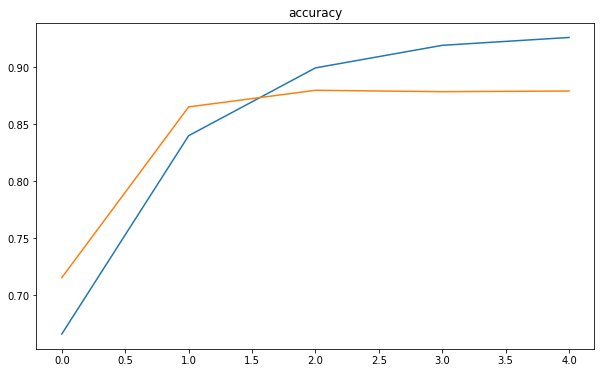

In [19]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Dropout(0.5))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional.add(keras.layers.Dropout(0.5))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=5, batch_size=128, validation_data=(X_valid_trim, y_valid))

plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

HYPERPARAMETERS TO AVOID OVERFITTING

To avoid overfitting without using any dropout layer, we can tune some hyperparameters. I doubled the batch size (to 256), which traduces to less weight updates, so less computing time and possibly less overfitting. On the other hand, by reducing the number of epochs, also overfitting is avoided. 

I tried decreasing the number of units in the bidirectional LSTM layer but it did not gave any performance improvement, actually the opposite. The benefit of this was just the save in computation time and cost. 

Finally, the best result I got is the following, obtained with 32 units, 4 epochs and 256 as batch size:

The bidirectional model without dropout performed:

- training: loss: 0.1259 - accuracy: 0.9599 

- validation: val_loss: 0.3669 - val_accuracy: 0.8706

- test: loss: 0.3463 - accuracy: 0.8764

while our model with the hyperparameter changes performed:

- loss: 0.1962 - accuracy: 0.9311 

- val_loss: 0.3039 - val_accuracy: 0.8770

- loss: 0.2897 - accuracy: 0.8828

which reduced the gap between training and test accuracy while slightly improving the accuracy.

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, None, 10)          100000    
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 64)                11008     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
98/98 [==============================] - 88s 862ms/step - loss: 0.6727 - accuracy: 0.5652 - val_loss: 0.4669 - val_accuracy: 0.8080
Epoch 2/4
98/98 [==============================] - 83s 851ms/step - loss: 0.4001 - accuracy: 0.8398 - val_loss: 0.3335 - val_accuracy: 0.8596
Epoch 3/4
98/98 [==============================] - 83s 849ms/step - loss: 0.2659 - accuracy: 

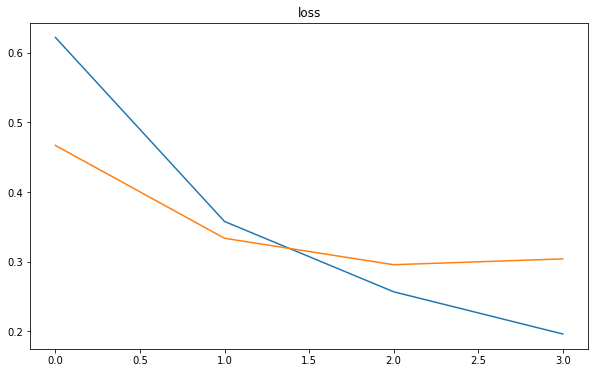

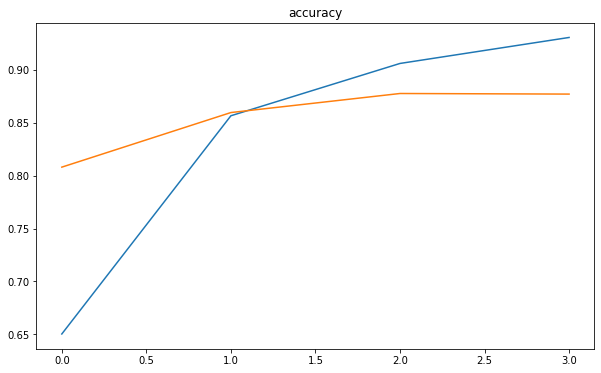

In [29]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=4, batch_size=256, validation_data=(X_valid_trim, y_valid))
plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

SOME OTHER MODELS I TRIED

I tried increasing the number of units to 48 and 56, both mantaining the others hyperparameters and changing the batch size and epoch number. This did not brought any improvement on the performance, but it was possible to avoid overfitting by setting this parameters accordingly (128, 196 and 256 batch size; 3, 4, 5 epochs).

One example of a model a tried which did not overfit:

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, None, 10)          100000    
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 96)                22656     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 97        
Total params: 122,753
Trainable params: 122,753
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
131/131 [==============================] - 135s 995ms/step - loss: 0.6502 - accuracy: 0.6059 - val_loss: 0.4363 - val_accuracy: 0.8302
Epoch 2/3
131/131 [==============================] - 130s 994ms/step - loss: 0.3459 - accuracy: 0.8580 - val_loss: 0.3165 - val_accuracy: 0.8648
Epoch 3/3
131/131 [==============================] - 130s 996ms/step - loss: 0.2999 - a

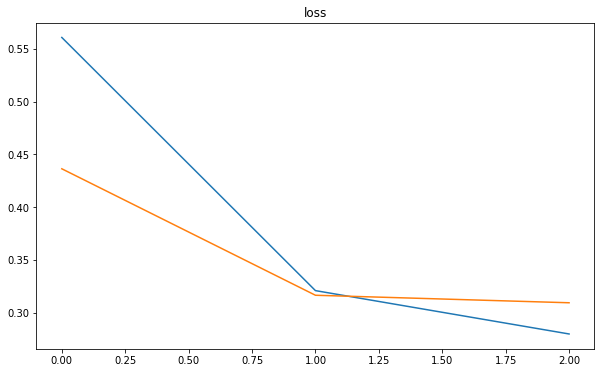

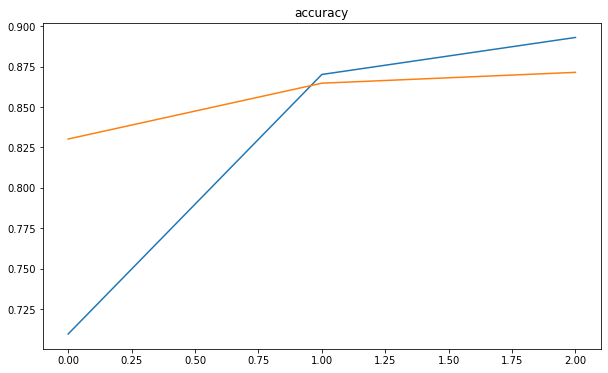

In [31]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(48)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=3, batch_size=256, validation_data=(X_valid_trim, y_valid))
plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))